<a href="https://colab.research.google.com/github/Strojove-uceni/final-projects-i_am_not_a_robot/blob/main/captcha_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install and load packages
! pip install patool
! pip install pyunpack

import argparse
import os
import random
import requests
import zipfile
import errno
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
from pyunpack import Archive
import glob
import string
from PIL import Image

     |████████████████████████████████| 77 kB 2.3 MB/s 


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

n_cudas = torch.cuda.device_count()

print(f'We are now using {device}. There are {n_cudas} available gpus.')

if torch.cuda.is_available():
    print(f'{torch.cuda.get_device_name(0)}')

We are now using cuda. There are 1 available gpus.
Tesla K80


# Data preprocessing

Train data available at: https://drive.google.com/file/d/1AswiYpd_CIab6swI-XA88H_IBj0Dyd3G

Test data available at: https://drive.google.com/file/d/1AsOV43Wc_ZR_1yMbesvq0uNAlUrqK7_Y

## Dimension
(No. files x width x height x channels)

Size of train data: 200 000 x 180 x 60 x 3

Size of test data: 50 000 x 180 x 60 x 3

In [3]:
# download files from google drive

# load train data
!gdown --id 1AswiYpd_CIab6swI-XA88H_IBj0Dyd3G
# load test data
!gdown --id 1AsOV43Wc_ZR_1yMbesvq0uNAlUrqK7_Y


Downloading...
From: https://drive.google.com/uc?id=1AswiYpd_CIab6swI-XA88H_IBj0Dyd3G
To: /content/captcha_train.tar.gz
100% 1.92G/1.92G [00:13<00:00, 138MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1AsOV43Wc_ZR_1yMbesvq0uNAlUrqK7_Y
To: /content/captcha_test.tar.gz
100% 480M/480M [00:10<00:00, 46.0MB/s]


In [4]:
# create folders to unzip data
! mkdir 'train'
! mkdir 'test'

In [5]:
# unzip data
Archive('captcha_train.tar.gz').extractall('train')
Archive('captcha_test.tar.gz').extractall('test')

In [6]:
# check number of files
train_labels = os.listdir('train/train')
print('train files:', len(train_labels))

test_labels = os.listdir('test/test')
print('test files:', len(test_labels))

train files: 199987
test files: 49998


In [7]:
# check distribution of symbols in train set

# These are all symbols the captchas will have
symbols = string.ascii_uppercase + string.ascii_lowercase + string.digits 

index = {}
for cha in symbols:
  index[cha] = 0


In [10]:
for item in train_labels:
  get_label = str(item).split('.')[0]
  for cha in get_label:
    index[cha] += 1

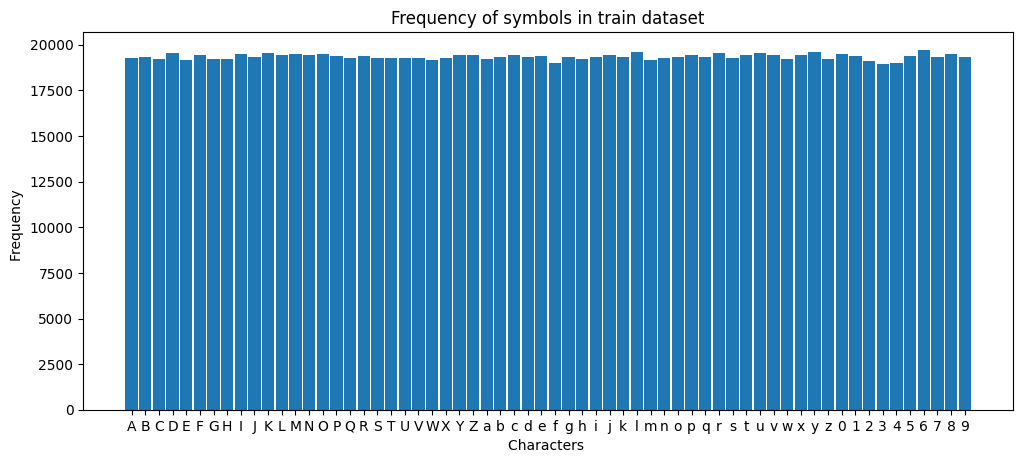

In [11]:
plt.figure(num=None, figsize=(12, 5), dpi=100, facecolor='w', edgecolor='k')
plt.bar(index.keys(), index.values(), width=0.9)
plt.title('Frequency of symbols in train dataset')
plt.xlabel("Characters ", fontsize=10)  
plt.ylabel("Frequency  ", fontsize=10)
plt.show()

## Create Data Loader

In [12]:
workers = 2                           # worker threads for loading the data with the DataLoader
batch_size = 128                      # size of batch
image_size = [60, 180]                # size of imput images
nc = 3                                # number of color channels in the input images

# normalization parameters
normalize_mean = (0.485, 0.456, 0.406)
normalize_std = (0.229, 0.224, 0.225)

# for reproducibility
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)

In [14]:
class Custom_Dataset(torch.utils.data.Dataset):
    
    def __init__(self, data_dir, data_labels):
        self.data_dir = data_dir
        self.data_labels = data_labels
        
    def __len__(self):
        return len(self.data_labels)
    
    def __getitem__(self, index):
        image_label = self.data_labels[index]
        image_fp = os.path.join(self.data_dir, image_label)
        image = Image.open(image_fp).convert('RGB')
        image = self.transform(image)
        text = image_label.split(".")[0]
        return image, text
    
    def transform(self, image):
        
        transform_ops = transforms.Compose([
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize(normalize_mean, normalize_std),
        ])
        return transform_ops(image)

In [15]:
# create dataloaders

dataset_train = Custom_Dataset('train/train', train_labels) 
dataset_test = Custom_Dataset('test/test', test_labels)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, num_workers=workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, num_workers=workers, shuffle=False)

print(len(train_loader), len(test_loader))

1563 391


In [16]:
# check dimensions
print(len(train_labels)/batch_size, len(test_labels)/batch_size)

1562.3984375 390.609375


In [17]:
# Decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [18]:
def UnNormalizeBatch(batch):
    for i in range(batch.shape[3]):
       batch[:,:,:,i] = (batch[:,:,:,i] * normalize_std[i]) + normalize_mean[i]

    return batch

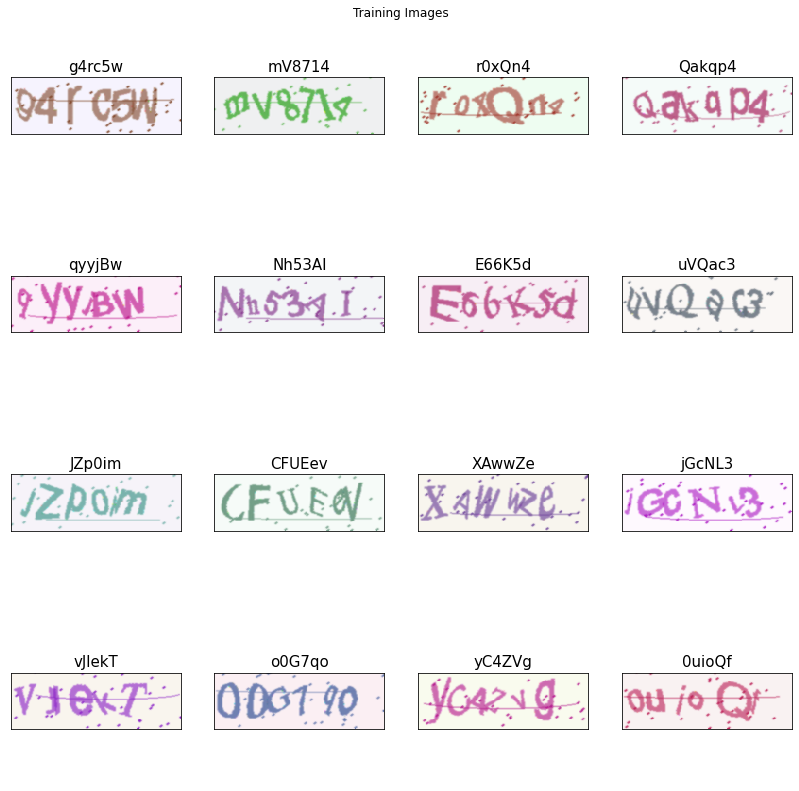

In [19]:
# view some train images
real_batch = next(iter(train_loader))
real_batch_pictures = np.transpose(real_batch[0].to(device).cpu().detach().numpy(),(0,2,3,1))
real_batch_pictures = UnNormalizeBatch(real_batch_pictures)

fig = plt.figure(figsize=(14,14))
plt.axis("off")
plt.title("Training Images")

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(real_batch_pictures[i], interpolation='nearest')
    plt.title(real_batch[1][i], color='k', fontsize=15)

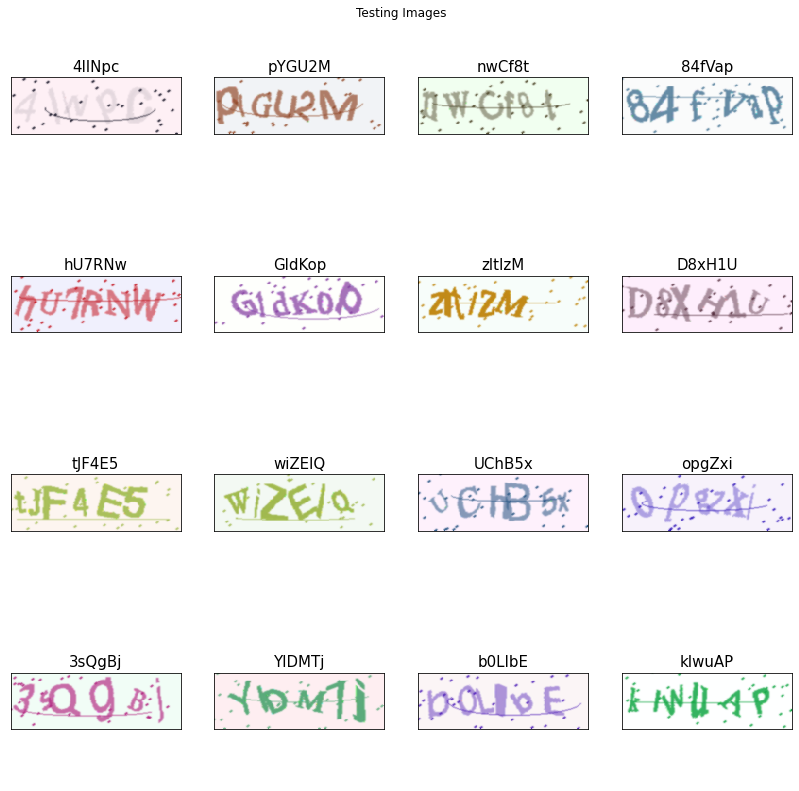

In [20]:
# view some test images
real_batch = next(iter(test_loader))
real_batch_pictures = np.transpose(real_batch[0].to(device).cpu().detach().numpy(),(0,2,3,1))
real_batch_pictures = UnNormalizeBatch(real_batch_pictures)

fig = plt.figure(figsize=(14,14))
plt.axis("off")
plt.title("Testing Images")

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(real_batch_pictures[i], interpolation='nearest')
    plt.title(real_batch[1][i], color='k', fontsize=15)

# Creating model